In [33]:
# Imports necesarios para detección de objetos
import torch
import torchvision
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

Device: cpu


In [34]:
# Lista de categorías COCO
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [35]:
# Función: cargar el modelo preentrenado
def load_pretrained_detector():
    model = fasterrcnn_resnet50_fpn(weights="DEFAULT")
    model.eval()
    model.to(device)
    return model

In [36]:
# Función: cargar y preprocesar una imagen
def load_image_as_tensor(image_path):
    img = Image.open(image_path).convert("RGB")
    img_tensor = transforms.ToTensor()(img)
    return img_tensor

In [37]:
# Función: hacer la predicción en una sola imagen
def predict_single_image(model, img_tensor, score_threshold=0.5):
    img_tensor = img_tensor.to(device)
    with torch.no_grad():
        outputs = model([img_tensor])
    
    # Extraer resultados de la primera (y única) imagen
    boxes = outputs[0]["boxes"]
    labels = outputs[0]["labels"]
    scores = outputs[0]["scores"]
    
    # Verificar si hay detecciones
    if len(boxes) == 0:
        return None, None, None
    
    # Filtrar por score_threshold
    mask = scores >= score_threshold
    if mask.sum() == 0:
        # Si no hay detecciones sobre el threshold, tomar la de mayor score
        best_idx = scores.argmax().item()
    else:
        # Filtrar y encontrar el mejor entre los filtrados
        filtered_scores = scores[mask]
        filtered_indices = torch.where(mask)[0]
        best_filtered_idx = filtered_scores.argmax().item()
        best_idx = filtered_indices[best_filtered_idx].item()
    
    # Obtener los valores de la mejor predicción
    best_score = scores[best_idx].item()
    best_box = boxes[best_idx].cpu().numpy()
    best_label_idx = labels[best_idx].item()
    
    # Convertir índice de label a nombre de clase
    best_label = COCO_INSTANCE_CATEGORY_NAMES[best_label_idx]
    
    return best_label, best_score, best_box

In [38]:
# Función: dibujar la caja y el texto sobre la imagen
def draw_prediction(image_path, label, score, box):
    # Cargar la imagen original
    img = Image.open(image_path).convert("RGB")
    
    # Crear figura
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    
    # Convertir box a coordenadas enteras
    xmin, ymin, xmax, ymax = map(int, box)
    
    # Crear rectángulo azul sin relleno
    rect = patches.Rectangle(
        (xmin, ymin),
        xmax - xmin,
        ymax - ymin,
        linewidth=2,
        edgecolor='blue',
        facecolor='none'
    )
    ax.add_patch(rect)
    
    # Crear texto con formato "score label"
    text = f"{score:.2f} {label}"
    
    # Dibujar texto sobre la esquina superior izquierda de la caja
    ax.text(
        xmin,
        ymin,
        text,
        bbox=dict(facecolor='blue', alpha=0.5),
        color='white',
        fontsize=10
    )
    
    # Quitar ejes y mostrar
    plt.axis("off")
    plt.show()

In [39]:

# Función principal
def main():
    # Rutas de las imágenes que quieres evaluar
    image_paths = [
        "/kaggle/input/imagesdog/images/dog.jpg",
        "/kaggle/input/imagesdog/images/kid(og).jpg",
        "/kaggle/input/imagesdog/images/unPerroDice.png",
    ]
    
    # Cargar el modelo preentrenado (una sola vez)
    print("Cargando modelo preentrenado...")
    model = load_pretrained_detector()
    print("Modelo cargado exitosamente\n")
    
    # Procesar cada imagen
    for image_path in image_paths:
        print(f"Procesando imagen: {image_path}")
        
        # Cargar y preprocesar la imagen
        img_tensor = load_image_as_tensor(image_path)
        
        # Obtener predicción
        label, score, box = predict_single_image(model, img_tensor, score_threshold=0.5)
        
        if label is None:
            print("  No se detectaron objetos en la imagen\n")
            continue
        
        # Imprimir resultado
        print(f"  Predicción: {label} con confianza {score:.2f}")
        print(f"  Caja: {box}\n")
        
        # Dibujar resultado
        draw_prediction(image_path, label, score, box)

Cargando modelo preentrenado...
Modelo cargado exitosamente

Procesando imagen: /kaggle/input/imagesdog/images/dog.jpg
  Predicción: dog con confianza 1.00
  Caja: [1145.4427  635.1852 1595.2794 1483.4293]



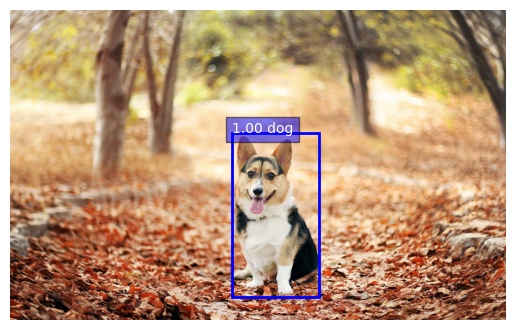

Procesando imagen: /kaggle/input/imagesdog/images/kid(og).jpg
  Predicción: person con confianza 0.99
  Caja: [ 23.719185    3.1750958 232.55339   190.75307  ]



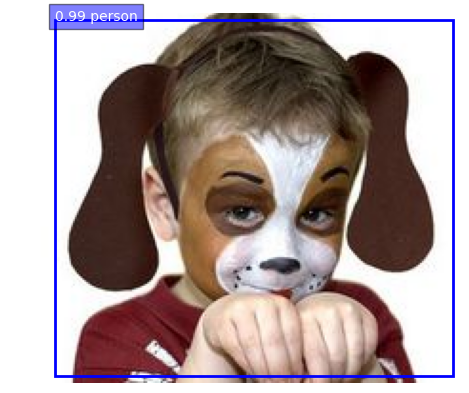

Procesando imagen: /kaggle/input/imagesdog/images/unPerroDice.png
  Predicción: person con confianza 0.98
  Caja: [  3.2656002  81.95709   398.94333   495.3937   ]



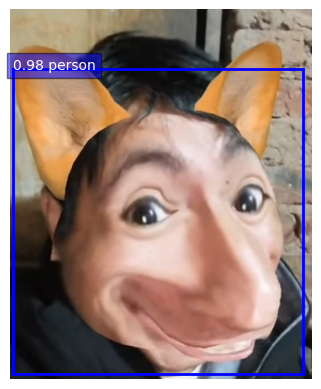

In [40]:
# Ejecutar el programa
main()